# Imports and helper functions

In [59]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
import numpy as np
from pandas import Series, plotting
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pmdarima.arima import auto_arima

TESTING = 'testing'
TRAINING = 'training'
INPUT = 'input'
OUTPUT = 'output'
TRAINING_PERCENTAGE = 0.8


def reshapedata(data: np.array, n_in: int, n_out: int) -> dict[np.array]:
    inarr = [np.array(data[i:i+n_in]) for i in range(len(data)-n_in-n_out+1)]
    outarr = [np.array(data[i:i+n_out]) for i in range(n_in, len(data)-n_out+1)]
    return {
        INPUT: np.array(inarr), 
        OUTPUT: np.array(outarr)
    }


def splitdata(data: np.array, trainpercentage: float) -> tuple[np.array, np.array]:
    idx = int(len(data) * trainpercentage)
    return {
        TRAINING: data[0:idx], 
        TESTING: data[idx:len(data)]
    }


def plotdata(indata: Series, prediction: Series, title: str, xlen: int, n_in: int) -> None:
    training_idx = int(len(indata) * TRAINING_PERCENTAGE)
    predictions_series = Series(
        prediction[:, 0], 
        index=indata.index[training_idx+n_in:training_idx+n_in+len(prediction)])

    plt.plot(indata, color='blue', linestyle='-', label='actual')
    plt.plot(predictions_series, color='red', linestyle='--', label='prediction')
    plt.title(title)
    plt.axvline(TRAINING_PERCENTAGE * xlen, color='black', linestyle='--')
    plt.xlim(indata.index[int(0.5*len(indata.index))], indata.index[len(indata.index) - 1])
    plt.show()


def predictdata(indata: Series, model: Sequential, n_in: int, n_out: int) -> tuple[np.array, float]:
    data = np.array(indata.values)
    splitteddata = splitdata(data, TRAINING_PERCENTAGE)
    training_data = reshapedata(splitteddata[TRAINING], n_in, n_out)
    testing_data = reshapedata(splitteddata[TESTING], n_in, n_out)

    model.fit(training_data[INPUT], training_data[OUTPUT], epochs=100, verbose=0)
    predictions = model.predict(testing_data[INPUT], verbose=0)
    mse = mean_squared_error(predictions, testing_data[OUTPUT])
    
    return predictions, mse


# check if randomly distributed
def israndom(data: Series, corr_limit: float) -> bool:
    output = sm.stats.acorr_ljungbox(data)
    return not (output['lb_pvalue'] < corr_limit).any()

# Task 1.1 - Prediction with MLP, RNN, LSTM using synthetic series

## Sub-task 1
An equal-difference series starting from 0, ending to 1 (excluding 1), with a length of 200 points (step = 0.005).
Design an MLP for one-step prediction. The output vector has a size of 1. Let the input vector be a size of 4.

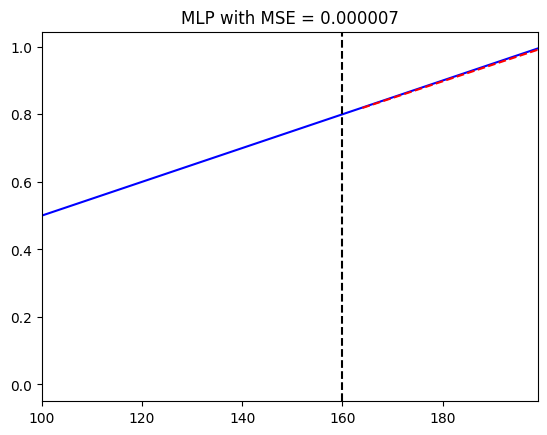

In [186]:
# Multi level perceptron (MLP) including hidden layer (100) and an output layer with 1 neuron
model = Sequential([
    Dense(100, activation='relu', input_dim=4),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

data = Series(np.arange(0, 1, 0.005))

pred, mse = predictdata(data, model, 4, 1)
plotdata(data, pred, f"MLP with MSE = {format(mse, '.6f')}", len(data), 4)

## Sub-task 2
An equal-difference series starting from 0, ending to 1, with a length of 200 points (step = 0.005), plus white noise i.e., random variable with zero mean and 1 variance. You may need to control the amplitude of the noise series in order to control the signal-noise ratio.
Design an MLP for one-step prediction. The output vector has a size of 1. Let the input vector be a size of 4.

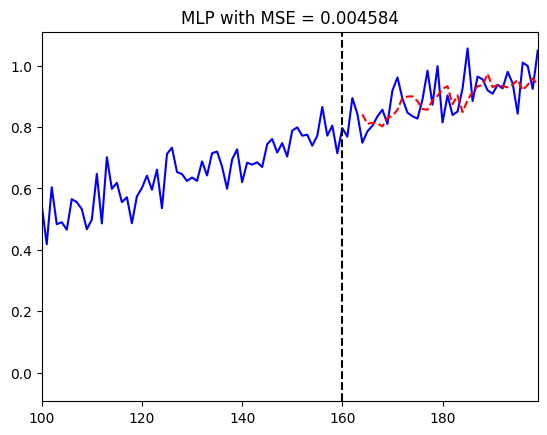

In [187]:
# model hidden layer with 100 neurons and output layer with 1 neuron
model = Sequential([
    Dense(100, activation='relu', input_dim=4),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

data = Series(np.arange(0, 1, 0.005)) 
data += np.random.normal(0, 0.05, data.shape)

pred, mse = predictdata(data, model, 4, 1)
plotdata(data, pred, f"MLP with MSE = {format(mse, '.6f')}", len(data), 4)

## Sub-task 3
A deterministic series sampled from a sinusoidal wave with period 20 seconds, with a sample rate of 100 Hz. Generate sufficient samples (at least 3 periods of data) as needed to achieve good performance, e.g. MSE (mean squared error) below 0.5.

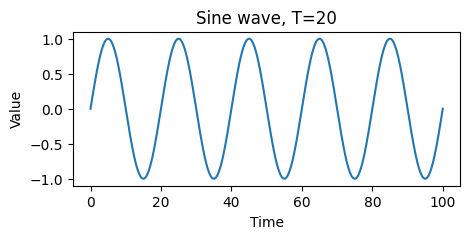

In [ ]:
period = 20
periods = 5
sample_rate = 100

timestamps = np.linspace(0, periods * period, sample_rate * periods)
sinedata = Series(timestamps).map(lambda t: np.sin(2*np.pi / period * t))
sinedata.index = timestamps
sinedata.plot(figsize=(5, 2), kind='line', xlabel='Time', ylabel='Value', title='Sine wave, T=20')
plt.show()

Design an RNN and a LSTM for two-step prediction. The output vector has a size of 2. Set the input vector size by yourself.

### RNN model

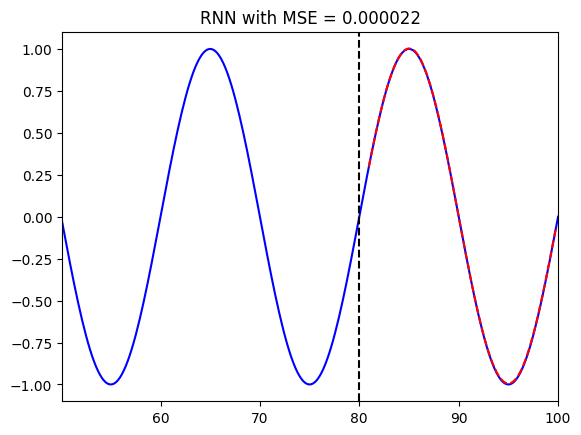

In [188]:
model = Sequential([
    SimpleRNN(units=100, input_shape=(4, 1), activation='relu'),
    Dense(units=2)
])
model.compile(optimizer='adam', loss='mse')

pred, mse = predictdata(sinedata, model, 4, 2)
plotdata(sinedata, pred, f"RNN with MSE = {format(mse, '.6f')}", periods * period, 4)

### LSTM model

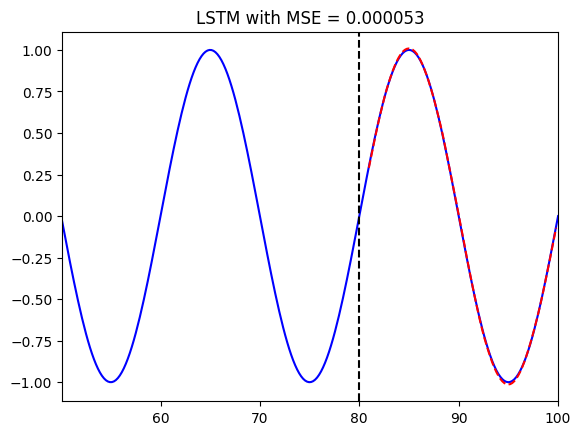

In [189]:
model = Sequential([
    LSTM(units=100, input_shape=(4, 1), activation='relu'),
    Dense(units=2)
])
model.compile(optimizer='adam', loss='mse')

pred, mse = predictdata(sinedata, model, 4, 2)
plotdata(sinedata, pred, f"LSTM with MSE = {format(mse, '.6f')}", periods * period, 4)

## Sub-task 4
A stochastic series sampled from a sinusoidal wave with period 20 seconds, with a sample rate of 100 Hz, plus random white noise i.e., random variable with zero mean and 1 variance. Control the amplitude of the noise with a fractional number, e.g. 0.1.

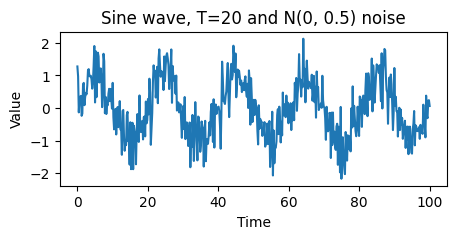

In [ ]:
period = 20
periods = 5
sample_rate = 100

timestamps = np.linspace(0, periods * period, sample_rate * periods)
sinedatawnoise = Series(timestamps).map(lambda t: np.sin(2*np.pi / period * t))
sinedatawnoise += np.random.normal(0, 0.5, sinedatawnoise.shape)
sinedatawnoise.index = timestamps
sinedatawnoise.plot(figsize=(5, 2), kind='line', xlabel='Time', ylabel='Value', title='Sine wave, T=20 and N(0, 0.5) noise')
plt.show()

Design an RNN and a LSTM for two-step prediction. The output vector has a size of 2. Set the input vector size by yourself.

### RNN model

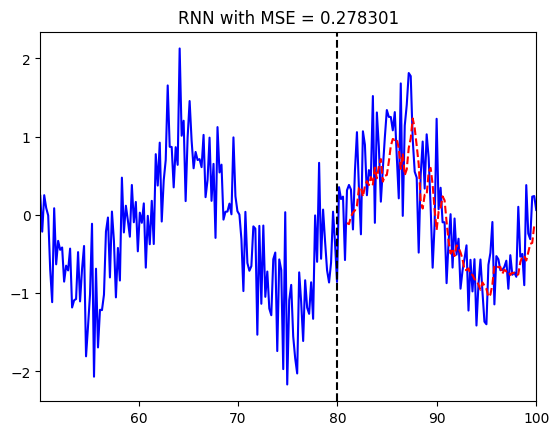

In [190]:
model = Sequential([
    SimpleRNN(units=100, input_shape=(4, 1), activation='sigmoid'),
    Dense(units=2)
])
model.compile(optimizer='adam', loss='mse')

pred, mse = predictdata(sinedatawnoise, model, 4, 2)
plotdata(sinedatawnoise, pred, f"RNN with MSE = {format(mse, '.6f')}", periods * period, 4)

### LSTM model

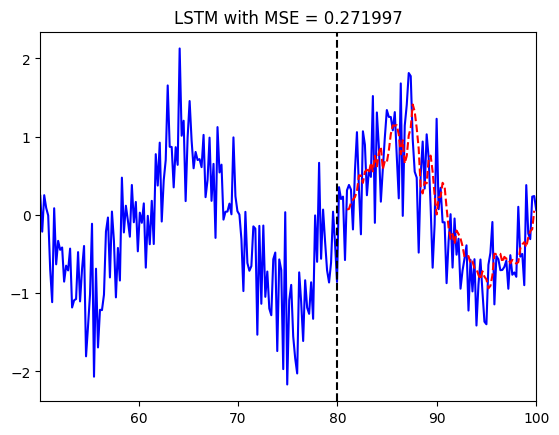

In [191]:
model = Sequential([
    LSTM(units=100, input_shape=(4, 1), activation='sigmoid'),
    Dense(units=2)
])
model.compile(optimizer='adam', loss='mse')

pred, mse = predictdata(sinedatawnoise, model, 4, 2)
plotdata(sinedatawnoise, pred, f"LSTM with MSE = {format(mse, '.6f')}", periods * period, 4)

# Task 1.2 - Predict white noise, a random walk and an ARMA process using neural networks

The dataset for this task should include the following three patterns of data, 1000 points in each
- A pure white-noise series with 1000 data points
- A random-walk series.
- A stationary series generated by an ARMA(2, 2) process. Make sure that the process with right parameters generates a stationary series.

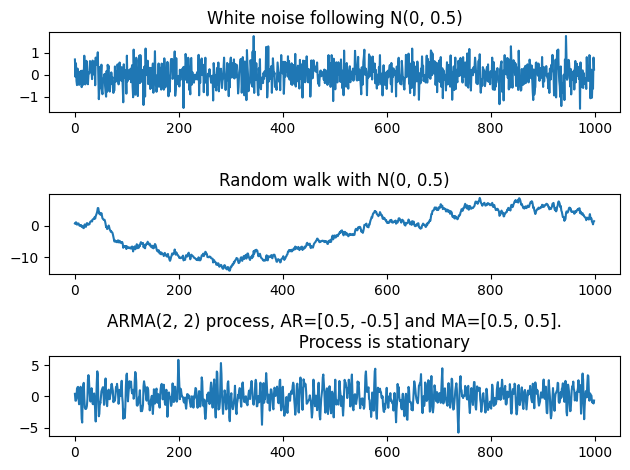

In [32]:
SAMPLE_SIZE = 1000
WN_series = Series(np.random.normal(0, 0.5, SAMPLE_SIZE))
RW_series = Series(WN_series.cumsum())
arcoeffs = np.array([0.5, -0.5])
macoeffs = np.array([0.5, 0.5])
proc = ArmaProcess(ar=np.r_[1, -arcoeffs], ma=np.r_[1, macoeffs])
ARMA_series = Series(proc.generate_sample(nsample=SAMPLE_SIZE))

fig, axes = plt.subplots(3, 1)
axes[0].plot(WN_series)
axes[0].set_title('White noise following N(0, 0.5)')
axes[1].plot(RW_series)
axes[1].set_title('Random walk with N(0, 0.5)')
axes[2].plot(ARMA_series)
axes[2].set_title(f'ARMA(2, 2) process, AR=[0.5, -0.5] and MA=[0.5, 0.5].\n \
                  Process is {"" if proc.isstationary else "not"}stationary')
plt.tight_layout()
plt.show()

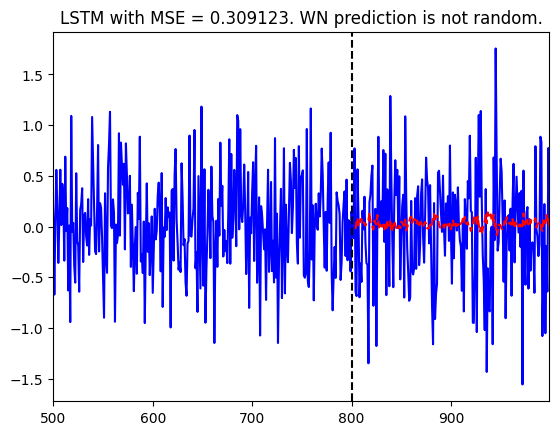

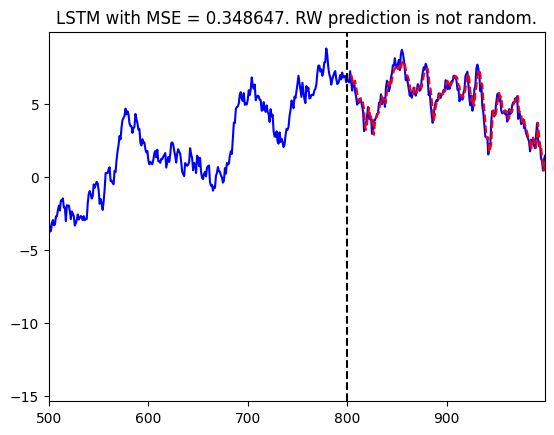

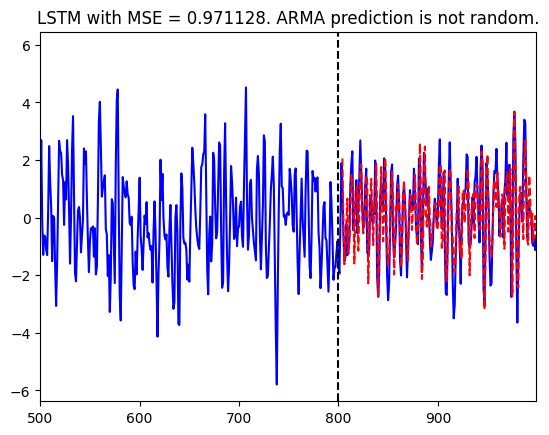

In [60]:
model = Sequential([
    LSTM(units=100, input_shape=(4,1), activation='sigmoid'),
    Dense(units=1)
])
model.compile(optimizer='adam', loss='mse')

WN_pred, WN_mse = predictdata(WN_series, model, 4, 1)
WN_is_random = f'{"" if israndom(WN_pred, 0.05) else "not "}random'
WN_title = f"LSTM with MSE = {format(WN_mse, '.6f')}. WN prediction is {WN_is_random}."
plotdata(WN_series, WN_pred, WN_title, SAMPLE_SIZE, 4)

RW_pred, RW_mse = predictdata(RW_series, model, 4, 1)
arma_is_random = f'{"" if israndom(RW_pred, 0.05) else "not "}random'
RW_title = f"LSTM with MSE = {format(RW_mse, '.6f')}. RW prediction is {arma_is_random}."
plotdata(RW_series, RW_pred, RW_title, SAMPLE_SIZE, 4)

ARMA_pred, ARMA_mse = predictdata(ARMA_series, model, 4, 1)
arma_is_random = f'{"" if israndom(ARMA_pred, 0.05) else "not "}random'
arma_title = f"LSTM with MSE = {format(ARMA_mse, '.6f')}. ARMA prediction is {arma_is_random}."
plotdata(ARMA_series, ARMA_pred, arma_title, SAMPLE_SIZE, 4)

# Task 1.3 - Comparison with ARIMA-based modeling and prediction

Generate a certain-length (e.g. 50 points) Fibonacci series and add standard Gaussian noise by yourself. Control the signal-noise ratio properly by controlling the amplitude of the signal and the noise, e.g. 95% of signal, 5% of noise.

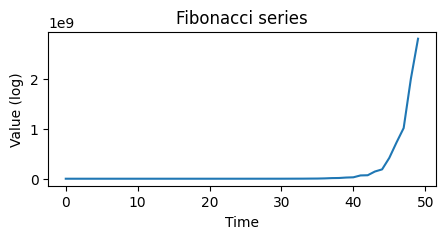

In [56]:
# create a fibonacci series of length 50
LEN = 50
fibonacci = Series(np.zeros(LEN), dtype=int)
fibonacci[1] = 1
for i in range(2, LEN):
    fibonacci[i] = int(fibonacci[i-1] + fibonacci[i-2]) + np.random.normal(0, fibonacci[i-1]*0.3)

fibonacci.plot(figsize=(5, 2), kind='line', xlabel='Time', ylabel='Value (log)', title='Fibonacci series')
plt.show()

Before creating the ARIMA model, its parameters p,d,q must be determined.

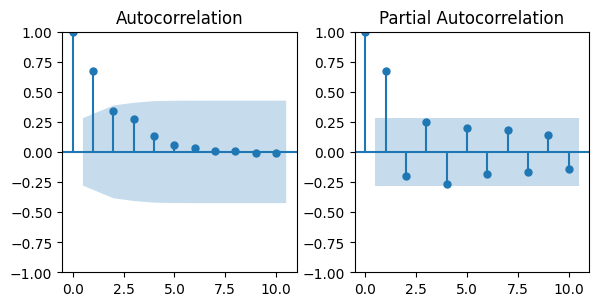

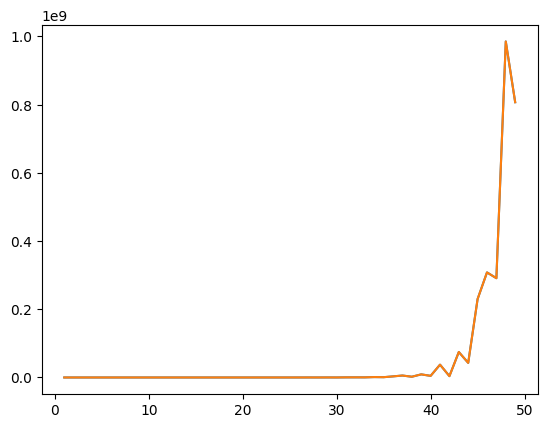

In [71]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
fig.subplots_adjust()
fig.tight_layout()
plot_acf(fibonacci.diff().dropna(), lags=10, ax=axes[0])
plot_pacf(fibonacci.diff().dropna(), lags=10, ax=axes[1], method='ywm')
plt.show()
plt.plot(fibonacci.diff().dropna())
fibonacci.diff().plot()
plt.show()
auto_arima(fibonacci.diff().dropna(), start_p=0, max_p=6, d=1, start_q=0, max_q=6, seasonal=False, information_criterion='aic')
q = 1
p = 0
d = 1

In [75]:
# mlp_model = Sequential([
#     Dense(units=100, input_shape=(4,), activation='relu'),
#     Dense(units=1)
# ])
# mlp_model.compile(optimizer='adam', loss='mse')

# lstm_model = Sequential([
#     LSTM(units=100, input_shape=(4, 1), activation='relu'),
#     Dense(units=1)
# ])
# lstm_model.compile(optimizer='adam', loss='mse')

# rnn_model = Sequential([
#     SimpleRNN(units=100, input_shape=(4, 1), activation='relu'),
#     Dense(units=1)
# ])
# rnn_model.compile(optimizer='adam', loss='mse')

arima_model = ARIMA(fibonacci[:40], order=(p, d, q)).fit()


# mlp_pred, mlp_mse = predictdata(fibonacci, mlp_model, 4, 1)
# mlp_title = f"MLP with MSE = {format(mlp_mse, '.6f')}."
# plotdata(fibonacci, mlp_pred, mlp_title, LEN, 4)

# rnn_pred, rnn_mse = predictdata(fibonacci, rnn_model, 4, 1) # changed epochs 100 -> 1000
# rnn_title = f"RNN with MSE = {format(rnn_mse, '.6f')}."
# plotdata(fibonacci, rnn_pred, rnn_title, LEN, 4)

# lstm_pred, lstm_mse = predictdata(fibonacci, lstm_model, 4, 1)
# lstm_title = f"LSTM with MSE = {format(lstm_mse, '.6f')}."
# plotdata(fibonacci, lstm_pred, lstm_title, LEN, 4)

# predict the next 4 values of the fibonacci series and convert back to original scale
arima_pred = arima_model.get_prediction(start=40, end=49).predicted_mean
arima_mse = mean_squared_error(fibonacci.diff()[40:], arima_pred)
print(f'ARIMA MSE = {format(arima_mse, ".6f")}.')
print(arima_pred)

ARIMA MSE = 171389144912268672.000000.
40    2.843196e+07
41    2.843196e+07
42    2.843196e+07
43    2.843196e+07
44    2.843196e+07
45    2.843196e+07
46    2.843196e+07
47    2.843196e+07
48    2.843196e+07
49    2.843196e+07
Name: predicted_mean, dtype: float64
